In [80]:
import pandas as pd
import numpy as np
import os
from xgboost import XGBRegressor

In [53]:
os.makedirs('model',exist_ok=True)

In [11]:
df = pd.read_csv('DailyDelhiClimateTrain.csv')
print(df.shape)
df.head()

(1462, 5)


,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [35]:
test = pd.read_csv('DailyDelhiClimateTest.csv')
test.date = pd.to_datetime(test.date)

In [12]:
df.date = pd.to_datetime(df.date)

In [40]:
df = pd.concat([df,test],axis=0)

<Axes: xlabel='date'>

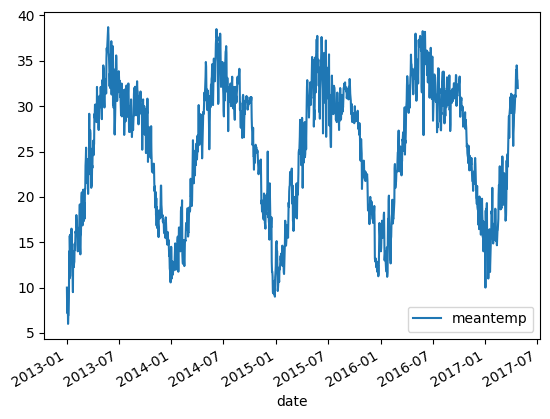

In [42]:
df.plot(x='date',y='meantemp')

<Axes: xlabel='date'>

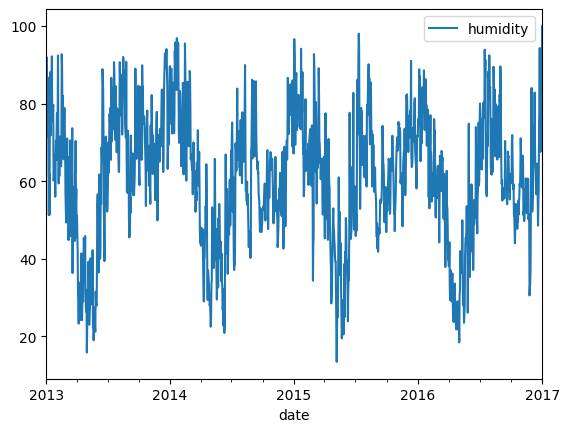

In [14]:
df.plot(x='date',y='humidity')

<Axes: xlabel='date'>

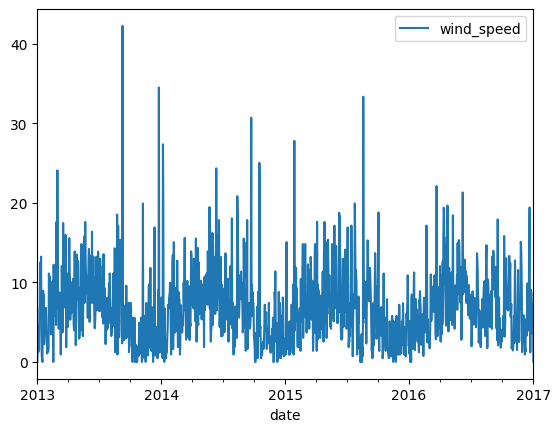

In [16]:
df.plot(x='date',y='wind_speed')

In [18]:
df.loc[0]['date']

Timestamp('2013-01-01 00:00:00')

In [28]:
def df_to_X_y(df,window_size):
    df_array = df.to_numpy()
    X = []
    y = []

    for i in range(len(df_array)-window_size):
        row = [[temp] for temp in df_array[i:i+window_size]]
        X.append(row)
        label = df_array[i+window_size]
        y.append(label)

    return np.array(X),np.array(y)

In [43]:
X,y = df_to_X_y(df['meantemp'],5)

In [46]:
X_train,y_train = X[:1000],y[:1000]
X_test,y_test = X[1000:1250],y[1000:1250]
X_val,y_val = X[1250:],y[1250:]

In [68]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

LSTM_model = Sequential()
LSTM_model.add(InputLayer((5,1)))
LSTM_model.add(LSTM(64))
LSTM_model.add(Dense(8,'relu'))
LSTM_model.add(Dense(1,'linear'))
LSTM_model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [69]:
cp = ModelCheckpoint('model/checkpoint.model.keras',save_best_only=True)
LSTM_model.compile(loss=MeanSquaredError(),optimizer=Adam(learning_rate=0.0005),
                   metrics=[RootMeanSquaredError()])


history = LSTM_model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=200,callbacks=[cp])

Epoch 1/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 731.4697 - root_mean_squared_error: 27.0451 - val_loss: 733.0146 - val_root_mean_squared_error: 26.5436
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 688.7557 - root_mean_squared_error: 26.2380 - val_loss: 718.1241 - val_root_mean_squared_error: 26.2684
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 698.5339 - root_mean_squared_error: 26.4240 - val_loss: 693.8262 - val_root_mean_squared_error: 25.8100
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 677.1337 - root_mean_squared_error: 26.0258 - val_loss: 651.1750 - val_root_mean_squared_error: 24.9854
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 632.8511 - root_mean_squared_error: 25.1490 - val_loss: 593.7803 - val_root_mean_squared_error: 23.8392
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 535.8519 - root_mean_squared_error: 23.1501 - val_loss: 537.8674 - val_root_mean_squared_error: 22.6692
Epoch 7/200
32/32 ━━━

In [72]:
history.history['loss']

[725.9736328125,
 700.744384765625,
 678.5726928710938,
 641.2627563476562,
 597.900634765625,
 538.9269409179688,
 489.76959228515625,
 439.2776184082031,
 394.69537353515625,
 349.6360778808594,
 310.0881652832031,
 276.50128173828125,
 245.04843139648438,
 218.31727600097656,
 194.212890625,
 166.9918670654297,
 147.99896240234375,
 130.2939453125,
 116.59153747558594,
 102.13090515136719,
 90.62425231933594,
 79.87871551513672,
 68.34607696533203,
 56.14519119262695,
 46.964576721191406,
 40.012752532958984,
 33.98988342285156,
 28.564842224121094,
 23.814607620239258,
 19.950902938842773,
 17.55368423461914,
 14.726435661315918,
 12.668952941894531,
 10.853029251098633,
 9.634528160095215,
 8.621220588684082,
 7.900118827819824,
 7.120140552520752,
 6.4072723388671875,
 5.953280925750732,
 5.471612453460693,
 5.256189823150635,
 5.032228946685791,
 4.785378456115723,
 4.446320533752441,
 4.384637832641602,
 4.2661213874816895,
 4.015130519866943,
 3.973301410675049,
 3.84367513656

In [74]:
train_predictions = LSTM_model.predict(X_train).flatten()
train_df = pd.DataFrame(data={'Train Predictions':train_predictions,'Actual':y_train})
train_df

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


,Train Predictions,Actual
0,8.234794,7.000000
1,8.556875,7.000000
2,8.723535,8.857143
3,10.175643,14.000000
4,13.676554,11.000000
...,...,...
995,29.115835,28.250000
996,28.832150,29.000000
997,29.480396,29.000000
998,29.398069,28.125000


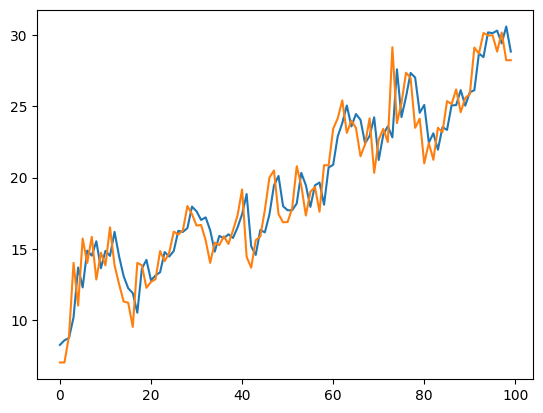

In [77]:
import matplotlib.pyplot as plt
plt.plot(train_df['Train Predictions'][:100])
plt.plot(train_df['Actual'][:100])

In [78]:
test_predictions = LSTM_model.predict(X_test).flatten()
test_df = pd.DataFrame(data={'Test Predictions':test_predictions,'Actual':y_test})
test_df

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


,Test Predictions,Actual
0,28.890688,30.000000
1,30.277014,29.000000
2,29.288147,28.875000
3,29.385750,28.375000
4,28.990740,28.625000
...,...,...
245,35.929630,38.200000
246,36.245949,36.166667
247,35.533527,35.428571
248,34.903908,34.625000


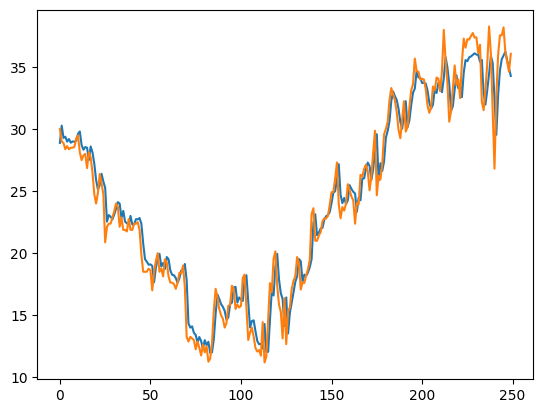

In [79]:
import matplotlib.pyplot as plt
plt.plot(test_df['Test Predictions'])
plt.plot(test_df['Actual'])

In [86]:
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['day'] = df['date'].dt.day
df['dayofyear'] = df['date'].dt.dayofyear

In [88]:
X = df.drop(['date','meantemp'],axis=1)
y = df['meantemp']

In [100]:
X_train = X.iloc[:1000,:]
y_train = y.iloc[:1000]

In [101]:
X_test = X.iloc[1000:1250,:]
y_test = y.iloc[1000:1250]

In [102]:
XGB_model = XGBRegressor()
XGB_model.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [103]:
predictions = XGB_model.predict(X_test)

In [104]:
y_test

1000    28.250000
1001    29.000000
1002    29.000000
1003    28.125000
1004    28.285714
          ...    
1245    26.812500
1246    32.642857
1247    36.000000
1248    37.562500
1249    37.562500
Name: meantemp, Length: 250, dtype: float64

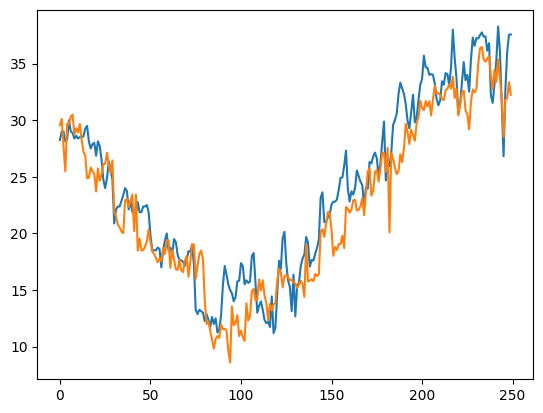

In [105]:
plt.plot(np.array(y_test))
plt.plot(predictions)